This is code that takes as input a diagram and creates knot diagrams that are concordant to the input knot.

In [1]:
import snappy
import itertools

#Methods to manipulate knot diagrams

def number_of_strands(PD_code):
    '''
    Returns the number of strands in a diagram.
    '''
    X=[]
    for cros in PD_code:
        X=X+[x for x in cros]
    return max(X)+1 

def get_next_strand(PD_code,strand,crossing):
    '''
    Returns the number of the next strand and its next crossing.
    '''
    PD=PD_code.copy()
    PD.remove(crossing)
    for cros in PD:
        for i in range(4):
            if cros[i]==strand:
                if i==0:
                    y=cros[2]
                if i==1:
                    y=cros[3]
                if i==2:
                    y=cros[0]
                if i==3:
                    y=cros[1]
                return [y,cros]
            
def replace_one_strand_in_crossing(PD_code,cros,old_strand,new_strand):
    '''
    Replaces first occurance of old_strand by new_strand in the crossing. 
    '''
    for i in range(4):
            if cros[i]==old_strand:
                if i==0:
                    new_cros=(new_strand,cros[1],cros[2],cros[3])
                if i==1:
                    new_cros=(cros[0],new_strand,cros[2],cros[3])
                if i==2:
                    new_cros=(cros[0],cros[1],new_strand,cros[3])
                if i==3:
                    new_cros=(cros[0],cros[1],cros[2],new_strand)
                PD_code.remove(cros)
                PD_code.append(new_cros)
                return PD_code

def change_crossing(PD_code,crossing):
    '''
    Changes the crossing.
    '''
    (a,b,c,d)=crossing
    PD_code.remove(crossing)
    PD_code.append((d,a,b,c))
    return PD_code


def strands_in_same_region(PD,strand1,strand2):
    '''Returns True if strand1 and strand2 are in the boundary of the same region of the diagram and False if not.
    We also return a pair of crossings that lie on the same 'side' of the strands 1 and 2, so that we can attach bands.
    WARNING: Might not work if Reidemeister 1 simplifications are posible.'''
    for crossing in PD:
        if strand1 in crossing:
            break
    #crossing contains strand1
    m=number_of_strands(PD)
    
    #Next we run through the knot and always turn to the left and check if we get strand2
    cros=crossing
    strand=strand1
    for i in range(m):
        cros=get_next_strand(PD,strand,cros)[1]
        if strand2==cros[(cros.index(strand)+1)%4]:
            return [True,get_next_strand(PD,strand1,crossing)[1],cros]
        strand=cros[(cros.index(strand)+1)%4]
        if cros==crossing:
            break
    #Next we run through the knot and always turn to the right and check if we get strand2
    cros=crossing
    strand=strand1
    for i in range(m):
        cros=get_next_strand(PD,strand,cros)[1]
        if strand2==cros[(cros.index(strand)-1)%4]:
            return [True,get_next_strand(PD,strand1,crossing)[1],cros]
        strand=cros[(cros.index(strand)-1)%4]
        if cros==crossing:
            break
    return [False,False,False]

#Attach a ribbon band.

def attach_ribbon_band(PD_code,strand1,strand2,twists=0):
    '''Attach a ribbon band between strand1 and strand2 with the specified number of twists.
    Remark: Get the mirror by interchanging the strands.'''
    PD=PD_code.copy()
    [test,cros1,cros2]=strands_in_same_region(PD,strand1,strand2)
    if test==False:
        raise ValueError('The strands do not lie in the same region.')
    m=number_of_strands(PD)
    if cros1!=cros2:
        PD=replace_one_strand_in_crossing(PD,cros1,strand1,m+1)
        PD=replace_one_strand_in_crossing(PD,cros2,strand2,m+7)
    if cros1==cros2:
        PD=replace_one_strand_in_crossing(PD,cros1,strand1,m+1)
        cros2=PD[-1]
        PD=replace_one_strand_in_crossing(PD,cros2,strand2,m+7)
    PD.append((strand1,m+10,m+6,m+11))
    PD.append((m+11,m+6,m+12,m+5))
    PD.append((m+1,m+9,m+2,m+10))
    PD.append((m+9,m+3,m+8,m+2))
    PD.append((m+5,m+12,m+4,strand2))
    PD.append((m+3,m+7,m+4,m+8))
    try:
        snappy.Link(PD)
        if twists>0:
            PD=PD[:-2]
            PD.append((m+5,m+12,m+4,m+2*twists+11))
            PD.append((m+3,m+2*twists+12,m+4,m+8))
            PD.append((strand2,m+13,m+14,m+7))
            for i in range(twists-1):
                PD.append((m+13+2*i,m+13+2*i+2,m+13+2*i+3,m+13+2*i+1)) 
        if twists<0:
            twists=-twists
            PD=PD[:-2]
            PD.append((m+5,m+12,m+4,m+2*twists+11))
            PD.append((m+3,m+2*twists+12,m+4,m+8))
            PD.append((strand2,m+13,m+14,m+7))
            for i in range(twists-1):
                PD.append((m+13+2*i,m+13+2*i+2,m+13+2*i+3,m+13+2*i+1)) 
            for i in range(1,twists):
                PD=change_crossing(PD,PD[-i])
                
    except ValueError:
        PD=PD_code.copy()
        PD=replace_one_strand_in_crossing(PD,cros1,strand1,m+1)
        PD=replace_one_strand_in_crossing(PD,cros2,strand2,m+7)
        PD.append((m+1,m+10,m+6,m+11))
        PD.append((m+11,m+6,m+12,m+5))
        PD.append((strand1,m+9,m+2,m+10))
        PD.append((m+9,m+3,m+8,m+2))
        PD.append((m+3,strand2,m+4,m+8))
        PD.append((m+5,m+12,m+4,m+7))
        if twists>0:
            PD=PD[:-2]
            PD.append((m+5,m+12,m+4,m+2*twists+11))
            PD.append((m+3,m+2*twists+12,m+4,m+8))
            PD.append((m+13,m+14,strand2,m+7))
            for i in range(twists-1):
                PD.append((m+13+2*i,m+13+2*i+2,m+13+2*i+3,m+13+2*i+1)) 
        if twists<0:
            twists=-twists
            PD=PD[:-2]
            PD.append((m+5,m+12,m+4,m+2*twists+11))
            PD.append((m+3,m+2*twists+12,m+4,m+8))
            PD.append((m+7,m+13,m+14,strand2))
            for i in range(twists-1):
                PD.append((m+13+2*i,m+13+2*i+2,m+13+2*i+3,m+13+2*i+1)) 
            for i in range(1,twists):
                PD=change_crossing(PD,PD[-i])
                
    return PD

#The code that creates concordant diagrams.

def concordance_search(PD_code,max_twists=5,bound=False,number_of_tries=100,verbose=False):
    '''Takes as input a diagram with no Reidemeister 1 simplification.
    Returns all possible diagrams obtained by attaching ribbon bands with at most 5 (or any other specified number)
    of twists.
    If the flag bound is set then only a fixed number of random diagrams gets created.'''
    if bound==False:
        PD=PD_code.copy()
        m=number_of_strands(PD)
        pairs = list(itertools.product(list(range(m)),list(range(m))))
        concordant_knots=[]
        for (a,b) in pairs:
            if a!=b:
                for T in range(-max_twists,max_twists+1):
                    try:
                        concordant_knots.append([attach_ribbon_band(PD,a,b,twists=T),a,b,T])
                    except ValueError:
                        pass
        return concordant_knots
    if bound:
        PD=PD_code.copy()
        m=number_of_strands(PD)
        concordant_knots=[]
        for i in range(number_of_tries):
            a=random.randint(0,m-1)
            b=random.randint(0,m-1)
            if a!=b:
                for T in range(-max_twists,max_twists+1):
                    try:
                        concordant_knots.append([attach_ribbon_band(PD,a,b,twists=T),a,b,T])
                    except ValueError:
                        pass
        return concordant_knots

Some examples:

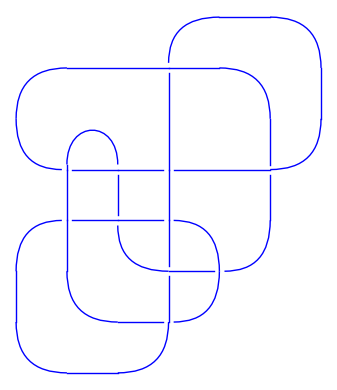

In [2]:
K=snappy.Link('K11n34')
PD=K.PD_code()
K.sage_link().plot()

In [3]:
strands_in_same_region(PD,15,2)

[True, (15, 21, 16, 20), (2, 0, 3, 21)]

In [4]:
snappy.Link(attach_ribbon_band(PD,0,11)).sage_link().plot()

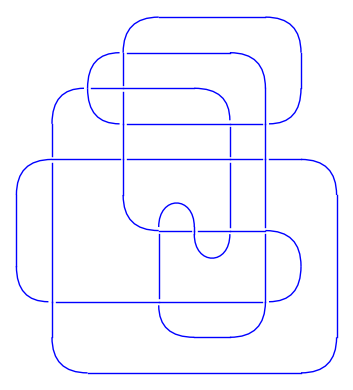

In [5]:
snappy.Link(attach_ribbon_band(PD,11,0)).sage_link().plot()

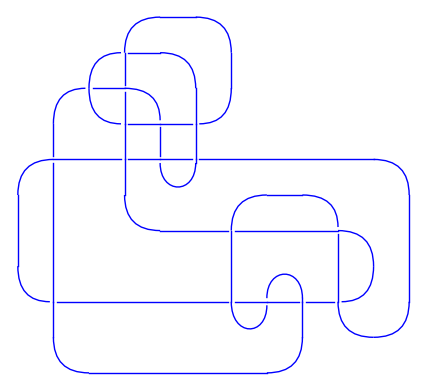

In [6]:
snappy.Link(attach_ribbon_band(PD,0,5)).sage_link().plot()

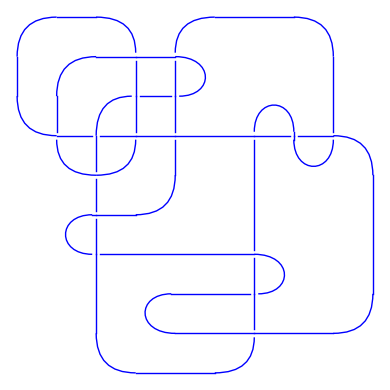

In [7]:
snappy.Link(attach_ribbon_band(PD,5,0)).sage_link().plot()

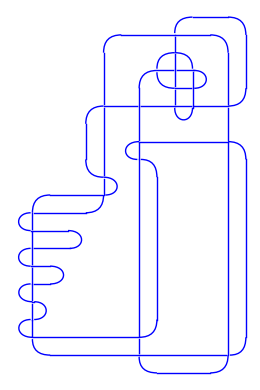

In [8]:
snappy.Link(attach_ribbon_band(PD,0,2,twists=-11)).sage_link().plot()

In [9]:
X=concordance_search(PD,max_twists=5)
len(X)

1320

A sanity check that they al have correct invariants:

In [11]:
for x in X:
    if (snappy.Link(x).signature())!=0:
        print(x)

In [12]:
for x in X:
    if snappy.Link(x).knot_floer_homology().get('tau')!=0:
        print(x)